# Semi-supervised Random Forests

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
import pdb
import random

In [2]:
random.seed(2019)

**Important Hyperparameters**
- $T_0$ and $\lambda$: the starting temperature and decay rate of the cooling function, respectively. These are the main two that concern us.
- $\alpha$: In the paper, all experiments were done with $\alpha = 0.1$.

**Temperature**: Our cooling function is $c(T) = T_0 \exp(-\lambda T)$ where $\lambda$ is our cooling parameter. When the temperature is high, the distribution is close to a uniform distribution and the labels sampled for the unlabeled set will be more random. On the other hand, at very low temperatures it approaches a Dirac distribution centered at whatever class minimized the margin-maximizing loss function $l(g_i(x))$ in Equation 19 of the paper.

In [3]:
class SSRF():
    
    def __init__(self, T0 = 1e-2, decay_rate = 0.15, alpha = 0.1):
        self.T0 = T0
        self.decay_rate = decay_rate
        self.alpha = alpha
        self.forests = None
        self.valid_errors = None
        self.test_errors = None
        self.oobe_errors = None
    
    # Cooling Function
    def cool(self, T):
        return(self.T0 * np.exp(-self.decay_rate * T))
    
    # Loss Function: Hinge Loss (Related to Gini index)
    @staticmethod
    def loss(margin_value):
        return(max(0, -margin_value))
    
    # New Fitted Class Distributions (Eq. 19)
    def compute_p_star(self, margin_vector, T):
        unnormalized_dist = [np.exp(-(self.alpha * self.loss(m) + T) / T) for m in margin_vector]
        normalized_dist = [i / sum(unnormalized_dist) for i in unnormalized_dist]
        return(normalized_dist)
    
    def train(self, X_l, y_l, X_u, X_test = None, y_test = None, n_trees = 100, n_epoch = 20,
              valid_size = 0.3):
        # Getting validation split and and showing size of sets
        X_l, X_l_valid, y_l, y_l_valid = train_test_split(X_l, y_l, test_size = valid_size)
        # Storing training data (for oobe)
        self.X_l, self.y_l, self.X_u = X_l, y_l, X_u
        # Setting Initial Temperature
        T = self.cool(0)
        # Training RF and getting initial validation error rate
        pdb.set_trace()
        labeled_rf = RandomForestClassifier(n_estimators = n_trees, oob_score = True).fit(X_l, y_l)
        valid_errors = [1 - labeled_rf.score(X_l_valid, y_l_valid)]
        oob_errors = [1 - labeled_rf.oob_score_]
        test_errors = [1 - labeled_rf.score(X_test, y_test)]
        forests = [labeled_rf]
        # Misc Setup For Algorithm
        n_u = X_u.shape[0]
        X_n = pd.concat((X_l, X_u))
        K = len(labeled_rf.classes_)
        # Main Loop
        for m in [i+1 for i in range(n_epoch)]:
            # Setup
            T = self.cool(T)
            prior_forest = forests[m-1]
            # Getting new probability distributions
            margins = prior_forest.predict_proba(X_u) - np.full((X_u.shape[0], K), 1 / K)
            p_star = np.apply_along_axis(self.compute_p_star, 1, margins, T = T)
            # Training new trees in forest
            new_forest = deepcopy(prior_forest)
            for tree in range(n_trees):
                y_u_hat = pd.Series([np.random.choice(prior_forest.classes_, p = p_star[i]) for i in range(n_u)])
                y_hat = pd.Series.append(y_l, y_u_hat)
                new_estimator = RandomForestClassifier(n_estimators=1).fit(X_n,y_hat).estimators_[0]
                new_forest.estimators_[tree] = new_estimator
            # Storing Forest and New Error Rates
            forests.append(new_forest)
            valid_errors.append(1 - new_forest.score(X_l_valid, y_l_valid))
            oob_errors.append(1 - self.get_oobe(new_forest))
            test_errors.append(1 - new_forest.score(X_test, y_test))
        self.forests = forests
        self.valid_errors = valid_errors
        self.oob_errors = oob_errors 
        self.test_errors = test_errors
    
    def errors(self):
        return([self.valid_errors, self.oob_errors, self.test_errors])
    
    def get_oobe(self, forest):
        n_labeled = self.y_l.shape[0]
        n_total = n_labeled + self.X_u.shape[0]
        classes = forest.classes_
        n_classes = len(classes)
        votes = np.zeros((n_labeled, n_classes))
        # Each estimator voting on its respective oob cases
        for estimator in forest.estimators_:
            unsampled_indices = SSRF._get_unsampled_labeled_indices(estimator.random_state, n_labeled, n_total)
            if unsampled_indices.shape[0] == 0:
                continue
            votes[unsampled_indices, :] += estimator.predict_proba(self.X_l.iloc[unsampled_indices, :])
        if (votes.sum(axis=1) == 0).any():
            warn("Some inputs do not have OOB scores. This probably means too few trees were used "
                 "to compute any reliable oob estimates.")
        # Comparing Predictions to y_l
        predictions = np.array([classes[i] for i in np.argmax(votes, axis = 1)])
        oobe = 1 - np.mean(np.array(self.y_l) == predictions)
        return(oobe)
    
    @staticmethod
    def _get_unsampled_labeled_indices(random_state, n_labeled, n_total):
        """ Exact the combination of 2 functions in sklearn.ensemble.RandomForestClassifer """ 
        # Getting unsampled indices (forest._generate_unsampled_indices)
        random_instance = check_random_state(random_state)
        sample_indices = random_instance.randint(0, n_total, n_total)
        sample_counts = np.bincount(sample_indices, minlength=n_total)
        unsampled_mask = sample_counts == 0
        indices_range = np.arange(n_total)
        unsampled_indices = indices_range[unsampled_mask]
        # Only keeping labeled unsampled indices
        unsampled_labeled_indices = unsampled_indices[unsampled_indices < n_labeled]
#         # Getting rid of unlabeled counts
#         sample_counts[n_labeled:] = np.ones(n_total - n_labeled)
#         # Finding unsampled and labeled indices
#         unsampled_mask = sample_counts == 0
#         indices_range = np.arange(n_total)
#         unsampled_indices = indices_range[unsampled_mask]
        return(unsampled_labeled_indices)

# Evaluation Procedure

In [4]:
def evaluate_SSRF(X, y, n_trees = 100, n_epoch = 20, valid_size = 0.3, prop_unlabeled = 0.95,
                 n_fold = 10, T0 = 1e-2, decay_rate = 0.15, alpha = 0.1):
    # Checking data types
    if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.Series):
        raise Exception("X and y must be a DataFrame and a series, respectively.")
    # Setup for plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
    ax1.set_ylim([0, 1.0])
    ax1.set_title("Validation Error")
    ax1.set_ylabel("Forest Error Rate")
    ax1.set_xlabel("Iteration")
    ax2.set_ylim([0, 1.0])
    ax2.set_title("OOB Error")
    ax2.set_ylabel("Forest Error Rate")
    ax2.set_xlabel("Iteration")
    ax3.set_ylim([0, 1.0])
    ax3.set_title("Test Error")
    ax3.set_ylabel("Forest Error Rate")
    ax3.set_xlabel("Iteration")
    # Cross-validating
    kf = KFold(n_splits = n_fold, shuffle = True)
    valid_errors, oob_errors, test_errors = [], [], []
    first_fold = True
    for train_index, test_index in tqdm(kf.split(X)):
        # Getting training (labeled and unlabeled) and testing
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_l, X_u, y_l, y_u = train_test_split(X_train, y_train,
                                              test_size = prop_unlabeled)
        # Displaying data sizes
        if first_fold:
            print("Labeled Training Set Size =", round(X_l.shape[0] * (1 - valid_size)),
                  "| Unlabeled Set Size =", X_u.shape[0],
                  "\nLabeled Validation Set Size =", round(X_l.shape[0] * valid_size),
                  "| Test Set Size =", X_test.shape[0])
            first_fold = False
        # Training SSRF
        ssrf = SSRF(T0, decay_rate, alpha)
        ssrf.train(X_l, y_l, X_u, X_test, y_test, n_trees, n_epoch, valid_size)
#         # Debugging
#         pdb.set_trace()
#         me = ssrf.get_oobe(ssrf.forests[0])
#         true = 1 - ssrf.forests[0].oob_score_
#         if (me == true).all():
#             print("OOBE Correct!")
        valid_error, oob_error, test_error = ssrf.errors()
        # Plotting and Storing Errors
        ax1.plot(valid_error, "b", alpha = 0.3)
        ax2.plot(oob_error, "g", alpha = 0.3)
        ax3.plot(test_error, "r", alpha = 0.3)
        valid_errors.append(valid_error)
        oob_errors.append(oob_error)
        test_errors.append(test_error)
    # Plotting Mean Errors
    mean_valid_error = np.mean(np.array(valid_errors), axis = 0)
    mean_oob_error = np.mean(np.array(oob_errors), axis = 0)
    mean_test_error = np.mean(np.array(test_errors), axis = 0)
    ax1.plot(mean_valid_error, "k")
    ax2.plot(mean_oob_error, "k")
    ax3.plot(mean_test_error, "k")
    plt.show()

# g50c
This [dataset](http://olivier.chapelle.cc/lds/) is from the original SS RF paper.

In [5]:
g50c = scipy.io.loadmat('data/g50c.mat')
g50c_X = pd.DataFrame(g50c["X"])
g50c_y = pd.Series(g50c["y"].ravel())

### Testing My OOBE vs. sklearn's OOBE

In [ ]:
# oobe testing code

### Regular Evaluation

In [ ]:
# TEST THESE VALUES TO GET IDEA OF WHAT decay_rate DOES
evaluate_SSRF(g50c_X, g50c_y, T0 = 4e-2, decay_rate = .05, n_fold = 3)
# evaluate_SSRF(g50c_X, g50c_y, T0 = 4e-2, decay_rate = 3., n_fold = 5)
# evaluate_SSRF(g50c_X, g50c_y, T0 = 4e-2, decay_rate = 6., n_fold = 5)

# P450

In [4]:
p450 = pd.read_csv("data/p450.csv")
p450_X = p450.iloc[:, 1:]
p450_y = p450.iloc[:, 0]

In [ ]:
evaluate_SSRF(p450_X, p450_y, T0 = 2e-2)

# Lactamase

In [66]:
lactamase = pd.read_csv("data/lactamase.csv")
lactamase_X = lactamase.iloc[:, 1:]
lactamase_y = lactamase.iloc[:, 0]

0it [00:00, ?it/s]

Training Set Size = 397.6 
Labeled Set Size = 74 
Unlabeled Set Size = 423 \Validation Set Size = 15 
Test Set Size = 56


10it [04:49, 28.90s/it]


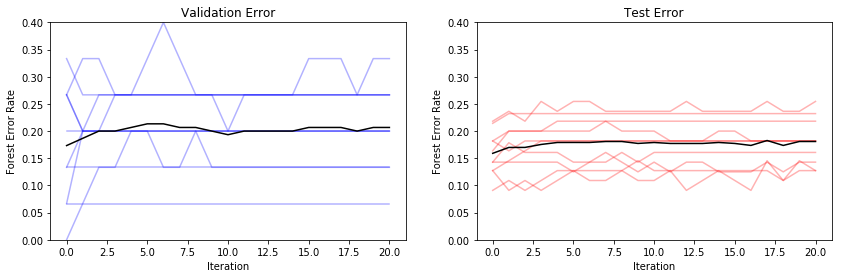

In [67]:
evaluate_SSRF(lactamase_X, lactamase_y)

# Letter
This [dataset](https://archive.ics.uci.edu/ml/datasets/letter+recognition) is from the original SS RF paper.

In [8]:
letter = pd.read_csv("data/letter.csv")
letter_X = letter.iloc[:, 1:]
letter_y = letter.iloc[:, 0]

In [ ]:
evaluate_SSRF(letter_X, letter_y, T0 = 1e-4, decay_rate = 0.35, alpha = 0.1, n_fold = 5)